/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
neptune: Executing in Offline Mode.


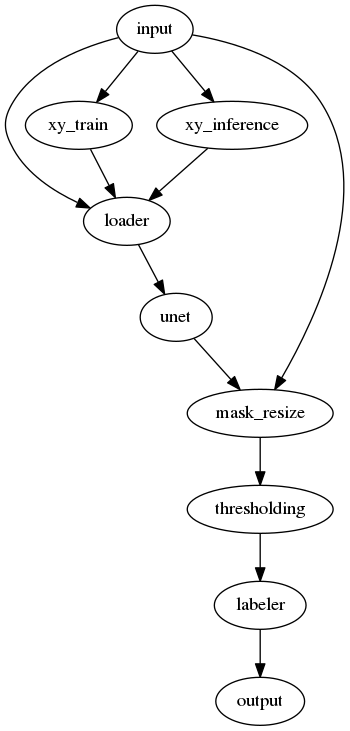

In [1]:
from pipelines import unet_multitask
from pipeline_config import SOLUTION_CONFIG

pipe = unet_multitask(SOLUTION_CONFIG, train_mode=True)
pipe

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from preparation import train_valid_split


meta = pd.read_csv('/mnt/ml-team/dsb_2018/files/stage1_metadata.csv')

meta_train_ = meta[meta['is_train']==1]
meta_train, meta_valid = train_valid_split(meta, validation_size=0.2, valid_category_ids=[0,1])
meta_test = meta[meta['is_train']==0]

meta_train.head(3)

,ImageId,file_path_image,file_path_masks,file_path_mask,is_train,width,height,n_nuclei,file_path_centers,file_path_contours,vgg_features_clusters
666,feffce59a1a3eb0a6a05992bb7423c39c7d52865846da3...,/mnt/ml-team/dsb_2018/data/stage1_train/feffce...,/mnt/ml-team/dsb_2018/data/stage1_train/feffce...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,256,256,38.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,3.0
29,0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf5...,/mnt/ml-team/dsb_2018/data/stage1_train/0b0d57...,/mnt/ml-team/dsb_2018/data/stage1_train/0b0d57...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,696,520,7.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,2.0
315,76a372bfd3fad3ea30cb163b560e52607a8281f5b04248...,/mnt/ml-team/dsb_2018/data/stage1_train/76a372...,/mnt/ml-team/dsb_2018/data/stage1_train/76a372...,/mnt/ml-team/dsb_2018/files/masks_overlayed/st...,1,1024,1024,63.0,/mnt/ml-team/dsb_2018/files/centers_overlayed/...,/mnt/ml-team/dsb_2018/files/contours_overlayed...,8.0


In [15]:
meta_train_['vgg_features_clusters'].value_counts()

9.0    111
4.0    109
7.0     96
6.0     93
2.0     56
1.0     54
3.0     54
5.0     53
0.0     30
8.0     14
Name: vgg_features_clusters, dtype: int64

In [16]:
# Clustering

In [218]:
import ipywidgets as ipy

@ipy.interact(idx=ipy.IntSlider(min=0,max=10,value=0,step=1))
def explore(idx):
    filepaths = meta_train_[meta_train_['vgg_features_clusters']==idx]['file_path_image'].values
    plt.figure(figsize=(20,12))
    for i in range(5):
        plt.subplot(1,5,i+1)
        image = plt.imread(filepaths[i])
        plt.imshow(image)
    plt.show()

interactive(children=(IntSlider(value=0, description='idx', max=10), Output()), _dom_classes=('widget-interact',))

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from scipy.stats import itemfreq
import scipy.ndimage as ndi
from skimage.transform import resize

output = joblib.load('/mnt/ml-team/dsb_2018/kuba/trained_pipelines/epoch_312_check/outputs/unet_multitask')

masks = output['mask_prediction']
contours = output['contour_prediction']

ground_truth = [resize(plt.imread(filepath)[:,:,0]>0.5,(512,512)) for filepath in meta_valid['file_path_mask'].values]

/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [27]:
len(masks),len(ground_truth)

(84, 84)

/mnt/ml-team/homes/jakub.czakon/.env/dl_py3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


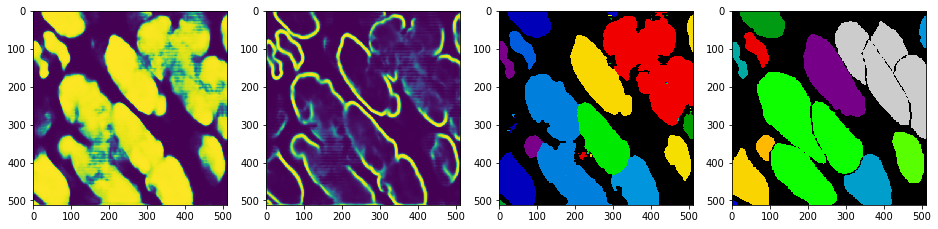

In [48]:
import numpy as np
from utils import relabel_random_colors, relabel
from metrics import compute_ious
from scipy.stats import itemfreq
import skimage.morphology as morph
import scipy.ndimage as nid


def watershed_contour(image, contour):
    mask = np.where(contour == 0, 0, image)

    distance = ndi.distance_transform_edt(mask)
    markers, nr_blobs = ndi.label(mask)
    labeled = morph.watershed(-distance, markers, mask=image)

    dropped, _ = ndi.label(image - (labeled > 0))
    dropped = np.where(dropped > 0, dropped + nr_blobs, 0)
    correct_labeled = dropped + labeled
    return relabel(correct_labeled)


def watershed_combined(image, contour, center):
    return watershed_contour(image, contour)

def fill_holes_per_blob(image):
    image_cleaned = np.zeros_like(image)
    for i in range(1,image.max()+1):
        mask = np.where(image==i,1,0)
        mask = ndi.morphology.binary_fill_holes(mask)
        image_cleaned = image_cleaned + mask*i
    return image_cleaned


for idx in [13]:
    m = masks[idx]
    c = contours[idx]
    t,_ = ndi.label(ground_truth[idx])
    mt = (m > 0.5).astype(np.uint8)
    ct = (t > 0.5).astype(np.uint8)
    w = watershed_contour(mt,ct)

    r = fill_holes_per_blob(w)
    
    p = r
#     print('{0:.2f}'.format(compute_eval_metric(t,p)))
    
    plt.figure(figsize=(16,12))
    plt.subplot(141)
    plt.imshow(m)
    plt.subplot(142)
    plt.imshow(c) 
    plt.subplot(143)
    plt.imshow(relabel_random_colors(r),cmap='spectral')   
    plt.subplot(144)
    plt.imshow(relabel_random_colors(t),cmap='spectral')
    plt.show()


In [44]:
?ndi.morphology.binary_fill_holes

https://surabhibhargava.github.io/Detection-and-Segmentation-of-Nuclei-in-Computational-Pathology/
    
    
    
http://openaccess.thecvf.com/content_ICCV_2017/papers/Liu_SGN_Sequential_Grouping_ICCV_2017_paper.pdf

http://www.bioimageanalysis.org/wp/wp-content/uploads/formidable/6/MIMO-Net_Isbi2017.pdf

https://arxiv.org/pdf/1607.04889.pdf

https://www.researchgate.net/profile/Yizhe_Zhang13/publication/319460791_Deep_Adversarial_Networks_for_Biomedical_Image_Segmentation_Utilizing_Unannotated_Images/links/59c9163fa6fdccc71929d61b/Deep-Adversarial-Networks-for-Biomedical-Image-Segmentation-Utilizing-Unannotated-Images.pdf

# Augmentations

In [6]:
from imgaug import augmenters as iaa
%matplotlib inline
import matplotlib.pyplot as plt
from augmentation import affine_seq, color_seq

In [236]:
raw = [plt.imread(filepath)[:,:,:3] for filepath in meta_valid['file_path_image'].values]
print(len(raw))

121


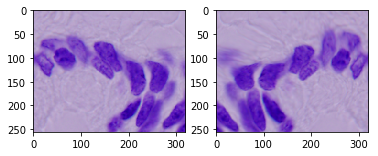

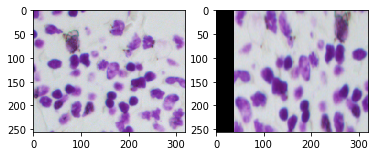

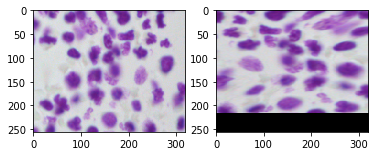

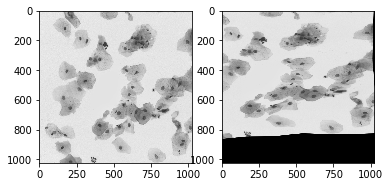

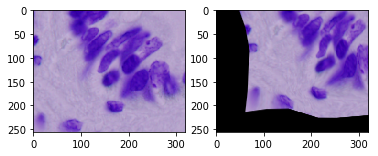

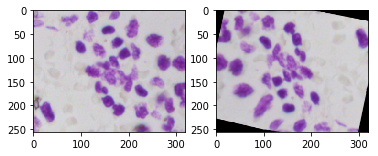

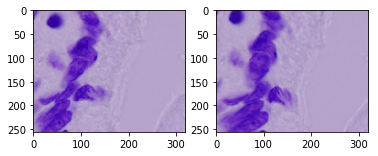

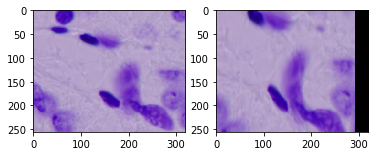

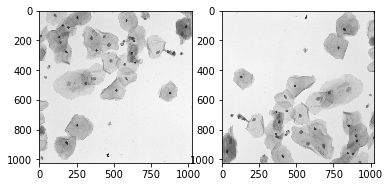

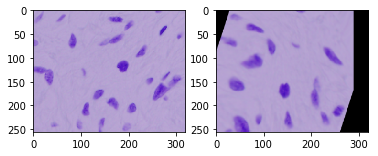

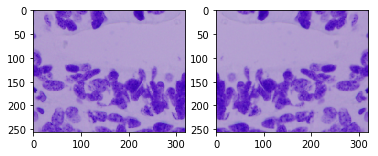

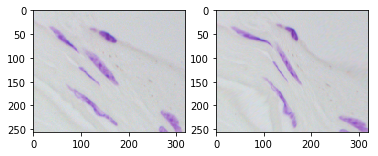

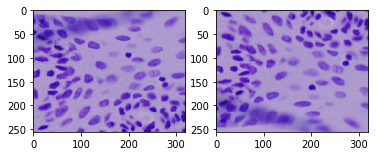

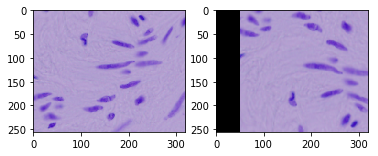

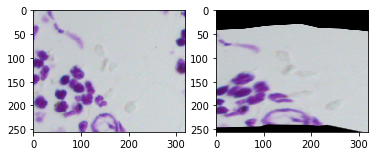

In [237]:
aug = affine_seq

for idx in np.random.choice(121,15):
    image = (raw[idx]*255).astype(np.uint8)
    augmented = aug.augment_image(image)
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    plt.imshow(augmented)
    plt.show()